In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [17]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [18]:
class DNN_2(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout1,dropout2,dropout3,dropout4):
        super(DNN_2, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)


        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [19]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [ ]:
def objective(trial):
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0.1, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0.1, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)

    model = DNN_2(input_dim=X_train_tensor.shape[1], hidden_units1=hidden_units1,hidden_units2=hidden_units2,hidden_units3=hidden_units3,hidden_units4=hidden_units4, dropout1=dropout1,dropout2=dropout2,dropout3=dropout3,dropout4=dropout4).to(device)


    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    val_true, val_pred, val_prob = [], [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val).squeeze()
            predictions = (val_outputs >0.49).float()
            val_true.extend(y_val.cpu().numpy())
            val_pred.extend(predictions.cpu().numpy())
            val_prob.extend(val_outputs.cpu().numpy())


    accuracy = accuracy_score(val_true, val_pred)
    precision = precision_score(val_true, val_pred)
    recall = recall_score(val_true, val_pred)
    f1 = f1_score(val_true, val_pred)
    mcc = matthews_corrcoef(val_true, val_pred)
    specificity = recall_score(val_true, val_pred, pos_label=0)

    # ログ
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return precision


In [21]:
# 使用可能なGPUの数を取得
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    print("使用可能なGPUはありません。")
else:
    print(f"使用可能なGPUの数: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  メモリ使用状況: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")
        print(f"  CUDA対応バージョン: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


使用可能なGPUの数: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 17.88 MB / 11169.31 MB
  CUDA対応バージョン: 6.1
GPU 1: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11172.19 MB
  CUDA対応バージョン: 6.1


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)


print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)


[I 2024-11-29 17:22:37,181] A new study created in memory with name: no-name-5dc0753e-807f-41e7-a7c2-9742770c7375
/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-29 17:23:29,608] Trial 0 finished with value: 0.5776566757493188 and parameters: {'hidden_units1': 388, 'hidden_units2': 138, 'hidden_units3': 122, 'hidden_units4': 26, 'dropout1': 0.5, 'dropout2': 0.2, 'dropout3': 0.1, 'dropout4': 0.1, 'learning_rate': 1.5367602211605223e-05}. Best is trial 0 with value: 0.5776566757493188.


Accuracy: 55.84%
Precision: 0.4398
Recall: 0.8413
F1 Score: 0.5777
Matthews Correlation Coefficient: 0.2495
Specificity: 0.4000


/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-29 17:24:18,800] Trial 1 finished with value: 0.5644599303135889 and parameters: {'hidden_units1': 218, 'hidden_units2': 188, 'hidden_units3': 90, 'hidden_units4': 44, 'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.03007171217071312}. Best is trial 0 with value: 0.5776566757493188.


Accuracy: 64.39%
Precision: 0.5031
Recall: 0.6429
F1 Score: 0.5645
Matthews Correlation Coefficient: 0.2766
Specificity: 0.6444


/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-29 17:25:11,706] Trial 2 finished with value: 0.5019011406844106 and parameters: {'hidden_units1': 412, 'hidden_units2': 174, 'hidden_units3': 114, 'hidden_units4': 56, 'dropout1': 0.2, 'dropout2': 0.35, 'dropout3': 0.2, 'dropout4': 0.25, 'learning_rate': 0.00015583851964593093}. Best is trial 0 with value: 0.5776566757493188.


Accuracy: 62.68%
Precision: 0.4818
Recall: 0.5238
F1 Score: 0.5019
Matthews Correlation Coefficient: 0.2048
Specificity: 0.6844


/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-29 17:26:02,977] Trial 3 finished with value: 0.4051724137931034 and parameters: {'hidden_units1': 354, 'hidden_units2': 188, 'hidden_units3': 110, 'hidden_units4': 12, 'dropout1': 0.1, 'dropout2': 0.1, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.013374912560182065}. Best is trial 0 with value: 0.5776566757493188.


Accuracy: 60.68%
Precision: 0.4434
Recall: 0.3730
F1 Score: 0.4052
Matthews Correlation Coefficient: 0.1158
Specificity: 0.7378


/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-29 17:26:53,850] Trial 4 finished with value: 0.48132780082987553 and parameters: {'hidden_units1': 314, 'hidden_units2': 214, 'hidden_units3': 84, 'hidden_units4': 38, 'dropout1': 0.1, 'dropout2': 0.45000000000000007, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.001210055056557553}. Best is trial 0 with value: 0.5776566757493188.


Accuracy: 64.39%
Precision: 0.5043
Recall: 0.4603
F1 Score: 0.4813
Matthews Correlation Coefficient: 0.2115
Specificity: 0.7467


/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-29 17:27:48,485] Trial 5 finished with value: 0.4146341463414634 and parameters: {'hidden_units1': 472, 'hidden_units2': 190, 'hidden_units3': 124, 'hidden_units4': 54, 'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dropout3': 0.2, 'dropout4': 0.25, 'learning_rate': 0.003572040937367434}. Best is trial 0 with value: 0.5776566757493188.


Accuracy: 58.97%
Precision: 0.4250
Recall: 0.4048
F1 Score: 0.4146
Matthews Correlation Coefficient: 0.0992
Specificity: 0.6933


/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-29 17:28:43,396] Trial 6 finished with value: 0.5017182130584192 and parameters: {'hidden_units1': 410, 'hidden_units2': 154, 'hidden_units3': 110, 'hidden_units4': 64, 'dropout1': 0.45000000000000007, 'dropout2': 0.4, 'dropout3': 0.1, 'dropout4': 0.45000000000000007, 'learning_rate': 0.01765818144012064}. Best is trial 0 with value: 0.5776566757493188.


Accuracy: 58.69%
Precision: 0.4424
Recall: 0.5794
F1 Score: 0.5017
Matthews Correlation Coefficient: 0.1638
Specificity: 0.5911


/tmp/ipykernel_183729/2559413743.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[W 2024-11-29 17:29:13,253] Trial 7 failed with parameters: {'hidden_units1': 350, 'hidden_units2': 212, 'hidden_units3': 74, 'hidden_units4': 30, 'dropout1': 0.30000000000000004, 'dropout2': 0.45000000000000007, 'dropout3': 0.2, 'dropout4': 0.45000000000000007, 'learning_rate': 0.0033010851379044557} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_183729/2559413743.py", line 27, in objective
    optimizer.step()
  File "/hom

KeyboardInterrupt: 

Epoch [1/100], Loss: 0.6021
Epoch [1/100], Train Loss: 0.6021, Val Loss: 0.5839
Epoch [2/100], Loss: 0.5854
Epoch [2/100], Train Loss: 0.5854, Val Loss: 0.5526
Epoch [3/100], Loss: 0.5817
Epoch [3/100], Train Loss: 0.5817, Val Loss: 0.5617
Epoch [4/100], Loss: 0.5830
Epoch [4/100], Train Loss: 0.5830, Val Loss: 0.5634
Epoch [5/100], Loss: 0.5761
Epoch [5/100], Train Loss: 0.5761, Val Loss: 0.5492
Epoch [6/100], Loss: 0.5699
Epoch [6/100], Train Loss: 0.5699, Val Loss: 0.5516
Epoch [7/100], Loss: 0.5732
Epoch [7/100], Train Loss: 0.5732, Val Loss: 0.5492
Epoch [8/100], Loss: 0.5772
Epoch [8/100], Train Loss: 0.5772, Val Loss: 0.5534
Epoch [9/100], Loss: 0.5783
Epoch [9/100], Train Loss: 0.5783, Val Loss: 0.5480
Epoch [10/100], Loss: 0.5798
Epoch [10/100], Train Loss: 0.5798, Val Loss: 0.5489
Epoch [11/100], Loss: 0.5689
Epoch [11/100], Train Loss: 0.5689, Val Loss: 0.5506
Epoch [12/100], Loss: 0.5704
Epoch [12/100], Train Loss: 0.5704, Val Loss: 0.5451
Epoch [13/100], Loss: 0.5715
Epoch

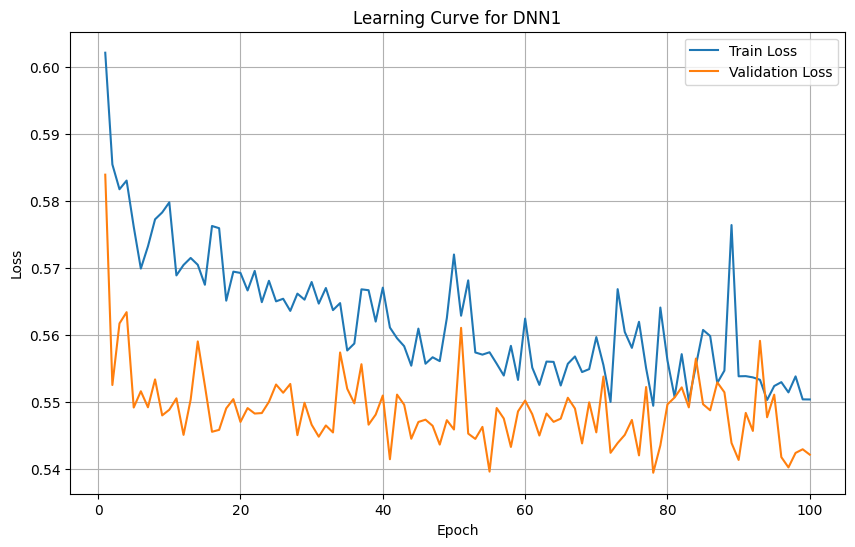

In [ ]:
best_params=study.best_params
model = DNN_2(input_dim=X_train_tensor.shape[1],
              hidden_units1=best_params["hidden_units1"],
              hidden_units2=best_params["hidden_units2"],
              hidden_units3=best_params["hidden_units3"],
              hidden_units4=best_params["hidden_units4"],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.09%
Precision: 0.4789
Recall: 0.9705
F1 Score: 0.6413
Matthews Correlation Coefficient: 0.3615
Specificity: 0.3358


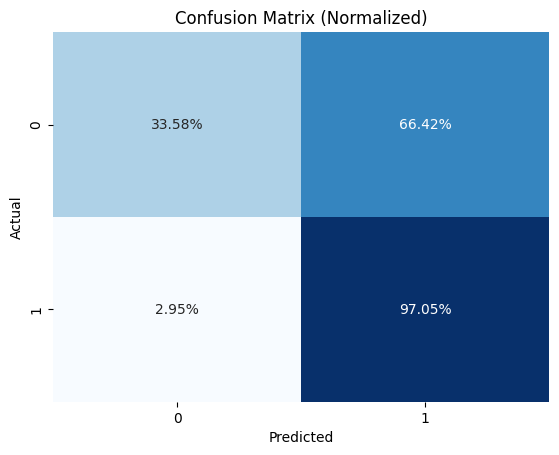

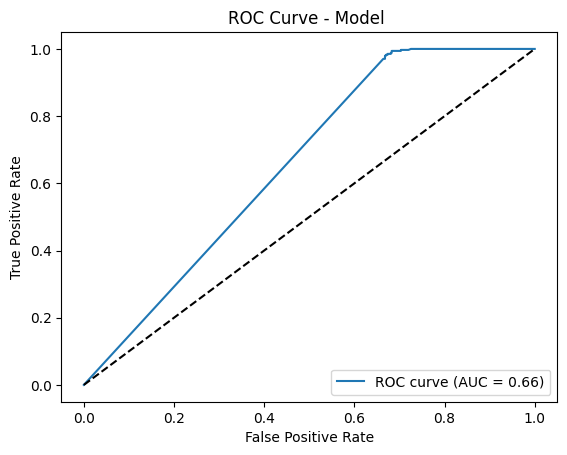

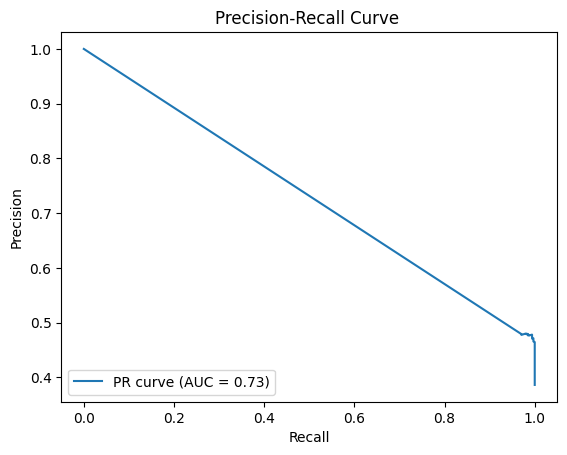

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs > 0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [ ]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_2.pth')
